# 3.3. Chunking Experiment

The search solution is comprised of both **ingestion** and **retrieval**. One does not exist without the other. While other experiments are focused on data retrieval, ingestion plays equal importance in the effectiveness of the search solution. During this experiment, we will look at various chunking strategies.

<!-- Certain aspects of data ingestion need to be experimented as part of the experimentation phase: -->

# Chunking Strategy

Code also https://github.com/microsoft/rag-openai/blob/438999a5470bef7946fa1c8714ed1090e1ed40c3/samples/searchEvaluation/customskills/utils/chunker/text_chunker.py

There are multiple methods of ingestion, depending on the type of data. For example, unstructured data such as documents or web pages can be split into chunks and embedded into vectors, while structured data such as tables or databases can be summarized or converted into natural language. In our case, since we are working with unstructured text data, we will look into different chunking strategies.

```{note}
Our goal here is not to identify which chunking strategy is the “best” in general but rather to demonstrate how the choice of chunking may have a non-trivial impact on the ultimate outcome from the RAG solution.
```

📝**Hypothesis**

The hypothesis for this experiment is an exploratory one: "Can introducing a new chunking strategy improve system's performance?"

🎯 **Measure of Success**

We will use a custom metric, where we will calculate the percentage of cases where the expected document is part of the retrieved documents. 
<!-- The metrics used for document retrieval evaluation. -->

<!-- [Learnings fromm other engagements](https://github.com/microsoft/rag-openai/blob/main/topics/RAG_EnablingSearch.md#learnings-from-engagements-1) -->

<!-- https://vectara.com/blog/grounded-generation-done-right-chunking/#:~:text=In%20the%20context%20of%20Grounded%20Generation%2C%20chunking%20is,find%20natural%20segments%20like%20complete%20sentences%20or%20paragraphs. -->

https://towardsdatascience.com/how-to-chunk-text-data-a-comparative-analysis-3858c4a0997a

<!-- https://blog.llamaindex.ai/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5

Example code: https://github.com/Azure/azure-search-vector-samples/blob/main/demo-python/code/data-chunking/textsplit-data-chunking-example.ipynb

Read [Common Chunking Technique](https://learn.microsoft.com/en-us/azure/search/semantic-search-overview), [Content overlap considerations](https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-chunk-documents#content-overlap-considerations), [Simple example of how to create chunks with sentences](https://learn.microsoft.com/en-us/azure/search/vector-search-how-to-chunk-documents#content-overlap-considerations)

CODE: https://github.com/microsoft/rag-openai/blob/438999a5470bef7946fa1c8714ed1090e1ed40c3/samples/searchEvaluation/customskills/utils/chunker/text_chunker.py -->


In [37]:
%run -i ./pre-requisites.ipynb

## 1. Fixed-sized chunks

This is one of the most basic form of splitting up text. It is the process of simply dividing the text into N-character sized chunks regardless of their content or form. This method isn't recommended for any applications - but it's a great starting point for us to understand the basics.

**Why Chunking Size Matters**

When processing data, splitting the source documents into chunks requires care and expertise to ensure the resulting chunks are small enough to be effective during fact retrieval but not too small so that enough context is provided during summarization. The models used to generate embedding vectors have maximum limits on the text fragments provided as input. For example, the maximum length of input text for the Azure OpenAI embedding models is **8,191** tokens. Given that each token is around 4 characters of text for common OpenAI models, this maximum limit is equivalent to around 6000 words of text. If you're using these models to generate embeddings, it's critical that the input text stays under the limit. Partitioning your content into chunks ensures that your data can be processed by the Large Language Models (LLM) used for indexing and queries.

**Relevance and Granularity**: A small chunk size, like 128, yields more granular chunks. This granularity, however, presents a risk: vital information might not be among the top retrieved chunks, especially if the similarity _top_k_ setting is as restrictive as 2. Conversely, a chunk size of 512 is likely to encompass all necessary information within the top chunks, ensuring that answers to queries are readily available. To navigate this, we employ the _Faithfulness and Relevancy_ metrics. These measure the absence of ‘hallucinations’ and the ‘relevancy’ of responses based on the query and the retrieved contexts respectively.

**Response Generation Time**: As the chunk_size increases, so does the volume of information directed into the LLM to generate an answer. While this can ensure a more comprehensive context, it might also slow down the system. Ensuring that the added depth doesn't compromise the system's responsiveness is crucial.

In essence, determining the optimal chunk_size is about striking a balance: capturing all essential information without sacrificing speed. It's vital to undergo thorough testing with various sizes to find a configuration that suits the specific use case and dataset.

- **Pros**: Easy & Simple
- **Cons**: Very rigid and doesn't take into account the structure of your text

Concept to know:

- **Chunk Size** - The number of characters you would like in your chunks. 50, 100, 100,000, etc.
- **Chunk Overlap** - The amount you would like your sequential chunks to overlap. This is to try to avoid cutting a single piece of context into multiple pieces. This will create duplicate data across chunks.


Let's load LangChain's `MarkdownTextSplitter` to split the text for us


In [26]:
from langchain.text_splitter import MarkdownTextSplitter

Let's load up the text splitted. You need to specify the `chunk overlap` and `chunk size`


In [96]:
chunk_size = 5
chunk_overlap = 3
markdown_splitter = MarkdownTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap)

We can split a text via `split_text` function. Let's take a sample text:


In [92]:
text = "This is the text I would like to chunk up. It is the example text for this exercise"

In [97]:
current_chunks_text_list = markdown_splitter.split_text(text)
current_chunks_text_list

['This is the text I',
 'the text I would like',
 'I would like to chunk',
 'like to chunk up.',
 'chunk up. It is',
 'It is the example text',
 'the example text for this',
 'text for this exercise']

Let's load our documents from Solution Ops Playbook


In [83]:
# import tqdm
import glob
from langchain_community.document_loaders import UnstructuredFileLoader
import os

In [84]:
def load_documents_from_folder(path, totalNumberOfDocuments=200) -> list[str]:
    print("Loading documents...")
    markdown_documents = []
    i = 0
    # tqdm.tqdm
    for file in glob.glob(path, recursive=True):
        loader = UnstructuredFileLoader(file)
        document = loader.load()
        markdown_documents.append(document)
        if i == totalNumberOfDocuments:
            return markdown_documents
        i += 1

In [6]:
totalNumberOfDocuments = 200
documents = load_documents_from_folder(
    "..\data\docs\**\*.md", totalNumberOfDocuments)

Loading documents...


  0%|          | 0/777 [00:00<?, ?it/s]

 26%|██▌       | 200/777 [00:13<00:39, 14.79it/s]


In [127]:
import json


def create_chunks_and_save_to_file(
    documents, path_to_output, chunk_size=300, chunk_overlap=30
) -> list:
    try:
        if os.path.exists(path_to_output):
            print(f"Chunks already created at: {path_to_output} ")
            return

        print("Creating chunks...")
        markdown_splitter = MarkdownTextSplitter.from_tiktoken_encoder(
            chunk_size=chunk_size, chunk_overlap=chunk_overlap
        )
        lengths = {}
        all_chunks = []
        chunk_id = 0
        for document in tqdm.tqdm(documents):
            current_chunks_text_list = markdown_splitter.split_text(
                document[0].page_content
            )
            for i, chunk in enumerate(
                current_chunks_text_list
            ):
                source = document[0].metadata["source"]
                current_chunk_dict = {
                    "chunkId": f"chunk{chunk_id}_{i}",
                    "chunkContent": chunk,
                    "source": source,
                }
                all_chunks.append(current_chunk_dict)

            chunk_id += 1

            n_chunks = len(current_chunks_text_list)
            # lengths = {[Number of chunks]: [number of documents with that number of chunks]}
            if n_chunks not in lengths:
                lengths[n_chunks] = 1
            else:
                lengths[n_chunks] += 1

        with open(path_to_output, "w") as f:
            json.dump(all_chunks, f)
        # print(f"Chunks created: ", lengths)
    except Exception as e:
        print(f"Error creating chunks: {e}")
    return lengths

Create the chunks

Note:

- we are only chunking the first `totalNumberOfDocuments` from `..\data\docs\**\*.md`
- `chunk_size` is the number of tokens a chunk should have
- `chunk_overlap` is the percentage of overlap between two chunks


In [5]:
totalNumberOfDocuments = 200
chunk_size = 300
chunk_overlap = 30
fixed_chunks_output_prefix = "fixed-size-chunks-solution-ops"

path_to_chunks_output = f"./output/generated/{fixed_chunks_output_prefix}-{totalNumberOfDocuments}-{chunk_size}-{chunk_overlap}.json"
print(path_to_chunks_output)


chunks = create_chunks_and_save_to_file(
    documents, path_to_chunks_output, chunk_size=chunk_size, chunk_overlap=chunk_overlap)

./output/generated/fixed-size-chunks-solution-ops-200-300-30.json


TypeError: stat: path should be string, bytes, os.PathLike or integer, not list

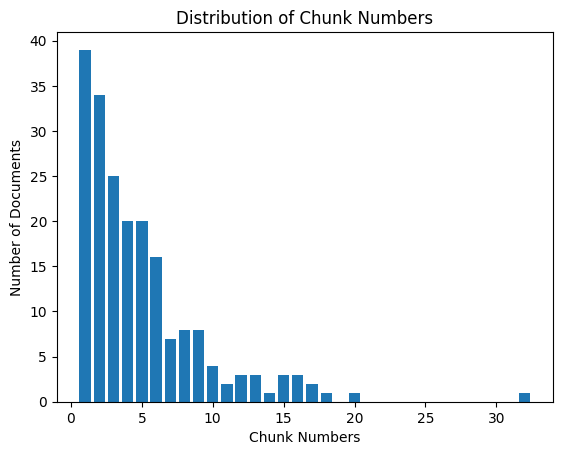

In [129]:
from matplotlib import pyplot as plt

# lengths = {[Number of chunks]: [number of documents with that number of chunks]}
x = chunks.keys()  # number of chunks per document
y = chunks.values()  # number of documents with that number of chunks

plt.bar(x, y)
plt.xlabel("Chunk Numbers")
plt.ylabel("Number of Documents")
plt.title("Distribution of Chunk Numbers")
plt.show()

In this workshop, to separate our experiments, we will take the _Full Reindex_ strategy by creating a new index


In [16]:
%run -i ./helpers/search.ipynb

# 1. Create the new index
fixed_chunking_index_name = "solution-ops-fixed-chunking-300-30"
create_index(fixed_chunking_index_name)

# 2. Generate embeddings for the new chunks
generated_embeddings_path = f"./output/generated/{fixed_chunks_output_prefix}-embedded-{totalNumberOfDocuments}-{chunk_size}-{chunk_overlap}.json"
generate_embeddings_for_chunks_and_save_to_file(path_to_chunks_file=path_to_chunks_output, path_to_output=generated_embeddings_path)

# 3. Upload the embeddings to the new index
upload_data(file_path=generated_embeddings_path, search_index_name=fixed_chunking_index_name)

### 2. Use [Semantic Chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)

Azure: https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augumented-generation?view=doc-intel-4.0.0#semantic-chunking)


In the previous approach, we chose a constant value for chunk size, in a random way. We did not leverage the actual content of the document, the structure, etc. In this section, we will look at [Semantic Chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker) from LangChain. This approach splits the text based on semantic similarity.

For insights on what it is doing, you can have a look at [Level 4. Semantic Splitting](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/5_Levels_Of_Text_Splitting.ipynb).


In [13]:
%run -i ./pre-requisites.ipynb
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from langchain_experimental.text_splitter import SemanticChunker

embeddings = AzureOpenAIEmbeddings(
    azure_deployment="embeddings",
    openai_api_version="2023-05-15",
)

with open("../data/docs/code-with-dataops/capabilities/analytical-systems/data-ingestion/batch-stream-ingestion/index.md") as f:
    state_of_the_union = f.read()

text_splitter = SemanticChunker(embeddings)

docs = text_splitter.create_documents([state_of_the_union])
print(docs[1].page_content)

This group is either determined by a specific time interval or a certain size limit. Stream ingestion deals with continuous, unbounded datasets. That said, most of the current stream ingestion approaches use mini-batches to ingest data as it reduces the number of I/O operations. ## Batch Ingestion

Traditionally data ingestion has been done in batches due to the limitations of the legacy systems. It still remains a popular way to ingest data for the simplicity of its implementation. Almost every ETL tool supports batch ingestion. ### Batch Ingestion Architectural Patterns

#### Pull

Most batch ingestion data pipelines will connect to a source system and pull data from it at regular interval. There are two common patterns for a batch job to load data from a source system, full load and delta load. - _Full load_: The job will load all the records from the source table. - _Delta load_: The job will load only the new records added since the last execution of the job. For this approach to 

### 👩‍💻 Create a function to chunk data from Solution-Ops using Semantic Chunker


In [4]:
import json


def create_semantic_chunks_and_save_to_file(documents, path_to_output) -> list:
    try:
        if os.path.exists(path_to_output):
            print(f"Chunks already created at: {path_to_output} ")
            return
        lengths = {}
        all_chunks = []
        chunk_id = 0
        # tqdm.tqdm(
        embeddings = AzureOpenAIEmbeddings(
            azure_deployment=azure_openai_embedding_deployment,
            openai_api_version="2023-05-15",
        )

        text_splitter = SemanticChunker(embeddings)
        for document in documents:
            content = document[0].page_content
            source = document[0].metadata["source"]

            splitted_documents = text_splitter.create_documents(
                [content])
            for i, splitted_content in enumerate(splitted_documents):
                current_chunk_dict = {
                    "chunkId": f"chunk{chunk_id}_{i}",
                    "chunkContent": splitted_content.page_content,
                    "source": source,
                }
                chunk_id += 1
                all_chunks.append(current_chunk_dict)
        with open(path_to_output, "w") as f:
            json.dump(all_chunks, f)
    except Exception as e:
        print(f"Error creating chunks: {e}")
    return all_chunks

In [5]:
totalNumberOfDocuments = 200
semantic_chunks_output_prefix = "semantic-chunks-solution-ops"
path_to_semantic_chunks_output = f"./output/generated/{semantic_chunks_output_prefix}-{totalNumberOfDocuments}.json"
print(path_to_semantic_chunks_output)

chunks = create_semantic_chunks_and_save_to_file(
    documents, path_to_semantic_chunks_output)

./output/generated/semantic-chunks-solution-ops-200.json


NameError: name 'documents' is not defined

In [22]:
%run -i ./helpers/search.ipynb

# 1. Create the new index
semantic_chunking_index_name = "solution-ops-semantic-chunking-200"
create_index(semantic_chunking_index_name)

# 2. Generate embeddings for the new chunks
generated_embeddings_path = f"./output/generated/{semantic_chunks_output_prefix}-embedded-{totalNumberOfDocuments}.json"
generate_embeddings_for_chunks_and_save_to_file(path_to_chunks_file=path_to_semantic_chunks_output, path_to_output=generated_embeddings_path)

# 3. Upload the embeddings to the new index
upload_data(file_path=generated_embeddings_path, search_index_name=semantic_chunking_index_name)

Index: 'solution-ops-semantic-chunking-200' created or updated
0
chunk0_0
1
chunk1_0
2
chunk2_1
3
chunk3_0
4
chunk4_1
5
chunk5_2
6
chunk6_0
7
chunk7_1
8
chunk8_0
9
chunk9_1
10
chunk10_0
11
chunk11_1
12
chunk12_0
13
chunk13_1
14
chunk14_2
15
chunk15_3
16
chunk16_0
17
chunk17_1
18
chunk18_2
19
chunk19_3
20
chunk20_0
21
chunk21_1
22
chunk22_2
23
chunk23_3
24
chunk24_0
25
chunk25_1
26
chunk26_2
27
chunk27_3
28
chunk28_4
29
chunk29_5
30
chunk30_6
31
chunk31_0
32
chunk32_1
33
chunk33_2
34
chunk34_0
35
chunk35_1
36
chunk36_2
37
chunk37_3
38
chunk38_0
39
chunk39_1
40
chunk40_0
41
chunk41_1
42
chunk42_2
43
chunk43_3
44
chunk44_4
45
chunk45_5
46
chunk46_6
47
chunk47_7
48
chunk48_8
49
chunk49_9
50
chunk50_0
51
chunk51_1
52
chunk52_2
53
chunk53_3
54
chunk54_4
55
chunk55_0
56
chunk56_1
57
chunk57_2
58
chunk58_3
59
chunk59_0
60
chunk60_1
61
chunk61_2
62
chunk62_0
63
chunk63_1
64
chunk64_2
65
chunk65_3
66
chunk66_4
67
chunk67_0
68
chunk68_1
69
chunk69_0
70
chunk70_1
71
chunk71_2
72
chunk72_3
73
chunk

In [97]:
text = "Data Mesh\n\nIntroduction\n\nData Mesh is an architectural pattern that aims to provide a self-service, decentralized model for data management and access within an organization. The concept of a Data Mesh encompasses data, technology, processes, and organization. An excellent overview can be found in Zhamak Dehghani\u2019s 2019 paper How to Move Beyond a Monolithic Data Lake to  Distributed Data Mesh, where she coined the term. Data Mesh is a democratized approach to managing data where various domains operationalize their own data. Typically, a domain can be thought of as a business unit that has overall accountability for an area within an organization. For example, financial services may have domains like customers, transactions, applications, fraud, etc. Data Mesh challenges the idea of conventional centralization of data and data management:\n\nRather than looking at data as one repository, Data Mesh considers the decomposition of a data estate into independent data products. As per Data Mesh concepts, data products are the primary areas for managing data. The approach presents a challenge in enforcing a minimum set of centralized governance policies and rules. The shift from centralized to federated ownership is backed by a modern and self-service data platform. The platform is typically designed using cloud-native technologies. Case for Data Mesh: Mesh vs. Monolith\n\nSimilar to DevOps, adopting a Data Mesh approach requires more than just technology; it necessitates a different organizational structure and culture. The reasons are outlined in Key Principles section. When a Data Mesh approach may be appropriate:\n\nAn organization has many autonomous teams that need to access and use data but with no central authority or process for managing data access and governance. An organization undergoing rapid growth or change with a need to adapt to new business needs and requirements quickly and flexibly. An organization looking to move to a more data-driven decision-making model with a need to establish clear ownership and accountability for data quality and usage. The scale of the organization is such that it has a growing need for self-service data onboarding and distribution. It allows decoupling from central IT management in turn speeding-up time to insights. When a Data Mesh approach may not be appropriate:\n\nThere are only a few teams/users who need access to data and there is already a robust, centralized process in place for access and governance. Data volumes are small. No requirement for self-service onboarding and data distribution. There are unresolved barriers for data sharing within the organization. For example - highly regulated domains might find it simpler to implement a tightly controlled, centralized model. Accompanying Repository\n\nMany of the practical aspects of implementing a Data Mesh have been applied in a recent Microsoft engagement, captured in a Microsoft internal repo. The repo is intended for illustrative purposes only and can be found in Code Hub. This repository contains Infrastructure as Code (IaC) components to create the Mesh Context and configurable Data Products. It also includes an example data product that consumes publicly available data concerning upcoming rocket launches. For space enthusiasts, the Code Hub Wiki contains detailed information on many publicly available datasets. It also contains APIs for space, in particular for launches and satellite tracking. Key Principles\n\nData as a Product\n\nEach domain operates its data end to end, creating Data Products. Accountability lies with the data owner within the domain. Data pipelines (as seen in traditional ETL/ELT patterns) in this respect become a first-class concern of the domains themselves. From a technical perspective, a data product is a software component that's built to deliver a specific data-related capability to its users. This capability can include things like providing access to a specific dataset, performing a certain data transformation, or delivering real-time analytics. The focus on the needs of users is the key characteristic of a data product. Also, a data product is designed to be independently deployable and operable. In other words, a data product is a purpose-built software component to deliver data-related functionality to users in an easy-to-use and understandable way. Federated Data Governance\n\nAn enterprise data governance body must be established to ensure trust between data owners and share data products. This governance body will implement: data quality, central visibility of data ownership, data access management, and data privacy policies. Domain-oriented Data Ownership\n\nThe enterprise should ideally define and model each data-domain product within the mesh by applying the principles of domain-driven design (see appendix). Self-serve Data Platform\n\nA self-serve data platform is required for a Data Mesh to allow users to focus on their individual data use cases and abstract the technical complexity. Data Mesh Roles\n\nThe main roles involved with a Data Mesh framework are explained in the sections below. Data product owners\n\nData product owners are the teams or individuals who are responsible for the data products within the mesh. They manage the data, ensure its quality and accuracy, and make sure it's being used effectively. Data platform owners\n\nData platform owners are the teams or individuals who are responsible for the overall infrastructure and management of the Data Mesh. They oversee the data governance and make sure that the data products are integrated and interoperable. Data consumers\n\nData consumers are the teams or individuals who use the data products within the mesh. They may be analysts, engineers, or other stakeholders who use the data to make decisions or build applications. In most organizations, these roles will interact with other core IT teams where there is an enterprise function. Below sections lists some of the teams and their roles. IT/DevOps teams\n\nIT/DevOps teams are responsible for the infrastructure and automation of the Data Mesh. They may be responsible for deploying new data products, ensuring best practices are in place, and handling any technical issues that arise. Security teams\n\nSecurity teams are responsible for ensuring the security and compliance of the Data Mesh. They may be responsible for managing identities, access control, and data encryption. Data Mesh Architectures\n\nIn this section we will look at the Data Mesh approach from several perspectives:\n\nSystem Context: Where a Data Mesh may sit in relation to other systems within an enterprise. Mesh Context: This context will outline typical components and resources that are shared across the mesh, and where \"data products\" fit. Data Product Context: Defining a Data Product, its core components and how various users can interact with them. Infrastructure Abstraction Context: Defining the abstractions that allow teams to use templates to build data products, saving time and reducing the need for extensive cloud expertise. System Context\n\nLike a standard modern data warehouse, a Data Mesh is intended to play a fundamental role in the information architecture of an enterprise. Ingesting data from operational systems into data products, performing the relevant transformations and analysis, and then supporting decision intelligence across the organization. When implemented correctly, Data Mesh should enable teams to easily and independently onboard data, facilitate the analytical enrichment through creation of new data products. A Data Mesh should also make it easier for data consumers to discover, trust and consume the data product. A Data Mesh should be easily governed and administered through centralized policy and governance controls. Mesh Context\n\nA Data Mesh architecture is intended to provide the following capabilities:\n\nDiscovery tools to quickly see available data and understand its content. Data Lineage to understand the history and dependencies of data."
len(text)

8008

In [18]:
# totalNumberOfDocuments = 200
# semantic_chunks_output_prefix = "semantic-chunks-solution-ops"
# path_to_semantic_chunks_output = f"./output/generated/{semantic_chunks_output_prefix}-{totalNumberOfDocuments}.json"
# generated_embeddings_path = f"./output/generated/{semantic_chunks_output_prefix}-embedded-{totalNumberOfDocuments}.json"

# !python ./helpers/api_request_parallel_processor.py \
#   --requests_filepath {path_to_semantic_chunks_output} \
#   --save_filepath {generated_embeddings_path} \
#   --request_url https://openai-adina.openai.azure.com/v1/embeddings \
#   --max_requests_per_minute 1500 \
#   --max_tokens_per_minute 6250000 \
#   --token_encoding_name cl100k_base \
#   --max_attempts 5 \
#   --logging_level 20

In [ ]:
# %pip install azure-ai-documentintelligence==1.0.0b1
# Quickstart: https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/quickstarts/try-document-intelligence-studio?view=doc-intel-4.0.0#prerequisites-for-new-users

In [36]:
# # Semantic chunking
# # https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augumented-generation?view=doc-intel-4.0.0

# # Using SDK targeting 2023-10-31-preview, make sure your resource is in one of these regions: East US, West US2, West Europe

# # pip install langchain langchain-community azure-ai-documentintelligence
# %run -i ./pre-requisites.ipynb
# from azure.ai.documentintelligence import DocumentIntelligenceClient

# endpoint = document_intelligence_endpoint
# key = document_intelligence_key

# from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
# from langchain.text_splitter import MarkdownHeaderTextSplitter

# # Initiate Azure AI Document Intelligence to load the document. You can either specify file_path or url_path to load the document.
# loader = AzureAIDocumentIntelligenceLoader(file_path="../data/docs/code-with-dataops/capabilities/analytical-systems/data-ingestion/batch-stream-ingestion/index.md", api_key = key, api_endpoint = endpoint, api_model="prebuilt-layout")
# docs = loader.load()

# # Split the document into chunks base on markdown headers.
# headers_to_split_on = [
#     ("#", "Header 1"),
#     ("##", "Header 2"),
#     ("###", "Header 3"),
# ]
# text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# docs_string = docs[0].page_content
# splits = text_splitter.split_text(docs_string)
# splits

https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker


# Use the built-in skillset: [SplitSkill](https://learn.microsoft.com/en-us/azure/search/cognitive-search-skill-textsplit)


<!-- Upload files to a storage account so we can create an Indexer
https://github.com/microsoft/rag-openai/blob/438999a5470bef7946fa1c8714ed1090e1ed40c3/samples/searchEvaluation/upload_files.py -->


## 📈 Evaluation

In this workshop, to separate our experiments, we will take the **Full Reindex** strategy and we will create a new index per chunking strategy.

<!-- Therefore, for each embedding model, what we will need to do is:

1. Create a new index. Note: make sure to give a relevant name.
2. Populate the index with the embeddings that you have generated at the previous steps.

```{note}
You can reuse available functions from [./helpers/search.ipynb](./helpers/search.ipynb), such as: *create_index* and *upload_data*. By running the next cell, all the functions from search.ipynb will become available.
``` -->

### Evaluation Dataset

Note: The evaluation dataset can be found at [solution-ops-200-qa.json](./output/qa/evaluation/solution-ops-200-qa.json). The format is:

```json
"user_prompt": "", # The question
"output_prompt": "", # The answer
"context": "", # The relevant piece of information from a document
"chunk_id": "", # The ID of the chunk
"source": "" # The path to the document, i.e. "..\\data\\docs\\code-with-dataops\\index.md"
```


Let us configure the path to evaluation dataset and reload environment variables


In [13]:
path_to_evaulation_dataset = "./output/qa/evaluation/solution-ops-200-qa.json"
%run -i ./pre-requisites.ipynb

### Evaluation Metric

We will use a custom evaluation metric, where we calculate the percentage of correctly retrieved documents

`Retrieval_evaluation` function goes through our evaluation dataset and verifies for each question if the retrieved documents include the expected document.


In [44]:
%run -i ./helpers/search.ipynb

In [11]:
import os


def retrieval_evaluation(evaluation_data_path, search_index_name, embedding_function=oai_query_embedding):
    """ Evaluate the retrieval performance of the search index using the evaluation data set.
    Args:
    evaluation_data_path (str): The path to the evaluation data set.
    embedding_function (function): The function to use for embedding the user prompts.
    search_index_name (str): The name of the search index to use for retrieval.

    Returns:
    float: The percentage of correctly retrieved documents.
    """
    if not os.path.exists(evaluation_data_path):
        print(
            f"The path to the evaluation data set {evaluation_data_path} does not exist. Please check the path and try again."
        )
        return
    nr_correctly_retrieved_documents = 0
    nr_qa = 0

    with open(evaluation_data_path, "r", encoding="utf-8") as file:
        evaluation_data = json.load(file)
        for data in evaluation_data:
            user_prompt = data["user_prompt"]
            expected_source_document = data["source"]

            # Search in the index and get the retrieved documents
            search_response = search_documents(
                search_index_name=search_index_name,
                input=user_prompt,
                embedding_function=embedding_function,
            )
            sources = [response["source"] for response in search_response]
            if expected_source_document in sources:
                nr_correctly_retrieved_documents += 1
            nr_qa += 1
    percentage = (nr_correctly_retrieved_documents / nr_qa)*100

    return percentage

#### Evaluate the fixed-size chunking strategy


In [17]:
# TODO: Replace this with the name of the index you want to evaluate
index_name = fixed_chunking_index_name

percentage = retrieval_evaluation(
    evaluation_data_path=path_to_evaulation_dataset,
    search_index_name=index_name,
)
print(f"{ percentage}% of the documents were correctly retrieved from Index {index_name} using OpenAI embedding model.")

33.33333333333333% of the documents were correctly retrieved from Index solution-ops-fixed-chunking-300-30 using OpenAI embedding model.


#### Evaluate the semantic chunking strategy


In [14]:
# TODO: Replace this with the name of the index you want to evaluate
index_name = semantic_chunking_index_name

percentage = retrieval_evaluation(
    evaluation_data_path=path_to_evaulation_dataset,
    search_index_name=index_name,
)
print(f"{ percentage}% of the documents were correctly retrieved from Index {index_name} using OpenAI embedding model.")

66.66666666666666% of the documents were correctly retrieved from Index solution-ops-semantic-chunking-200 using OpenAI embedding model.


## 💡 Conclusions
